In [1]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
epochs = 300

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 10))

width = 0.35
labels = [str(db) for db in range(-4, 6, 2)] + ['noise-free']
x = np.arange(len(labels))

for environ, ax in zip(environs, axes):
    unstr_bar = ax.bar(x - width/2, round(means.loc[str(epochs), 'activation'][f'metrics.test/acc_{environ}'], 2), width, label='Unstructured', color='C1', linewidth=1.5, edgecolor='black')
    str_bar = ax.bar(x + width/2, round(means.loc[str(epochs), 'channel'][f'metrics.test/acc_{environ}'], 2), width, label='Structured', color='C2', linewidth=1.5, edgecolor='black')

    ax.bar_label(unstr_bar, padding=3, fontsize=18)
    ax.bar_label(str_bar, padding=3, fontsize=18)

    dense = dense_acc.loc[str(epochs)][f'metrics.test/acc_{environ}']

    dense_line = ax.hlines(dense, 0, 1, transform=ax.get_yaxis_transform(), linewidth=3, linestyles='dashed', color='C0')

    if environ == 'cwru':
        ax.set_title('Noise-free', fontsize=28)
    else:
        ax.set_title('Noisy (0dB)', fontsize=28)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', labelsize=24, which='major', bottom=True, left=True, grid_color='none', color='black', length=8, width=2)

axes[0].set_ylim(30)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel('Sparsity', fontsize=28, labelpad=20)
ax.set_ylabel('Accuracy (%)', fontsize=28, labelpad=25)
ax.tick_params(grid_color='none',labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax.set_title(f'Epoch : {epochs}', y=1.1, fontsize=32)

legend = fig.legend([unstr_bar, str_bar, dense_line], ('Unstructured', 'Structured', 'Dense'), loc='lower left', bbox_to_anchor=(.99, 0.45), fontsize=24)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
fig.tight_layout()

In [598]:
experiments = mlflow.search_experiments(filter_string="name = 'wdcnn_cwru'")
runs = mlflow.search_runs(filter_string="params.model_name = 'wdcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  43.21 (±2.87)   
                                     0.5                                  41.28 (±2.85)   
                                     0.7                                  34.15 (±3.05)   
                                     0.9                                  31.95 (±2.76)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  63.61 (±2.55)   
                                     0.5                                  59.72 (±2.75)   
                                     0.7                                  50.70 (±3.87)   
                                     0.9                                  45.59 (±3.40)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 82.40 (±1.81)   
                                     0.5                                 77.24 (±2.02)   
                                     0.7                                 68.34 (±3.76)   
                                     0.9                                 61.82 (±3.51)   

                                                                metrics.test/acc_cwru2  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 93.20 (±1.09)   
                                     0.5                                 89.47 (±1.16)   
                                     0.7                                 82.46 (±2.68)   
                                     0.9                                 76.01 (±2.60)   

                                                                metrics.test/acc_cwru4  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 97.13 (±0.75)   
                                     0.5                                 95.64 (±0.57)   
                                     0.7                                 90.63 (±1.53)   
                                     0.9                                 85.32 (±1.63)   

                                                                metrics.test/acc_cwru  
params.epochs params.activation_drop params.activation_sparsity                        
100           activation             0.3                                99.44 (±0.22)  
                                     0.5                                99.56 (±0.17)  
                                     0.7                                99.15 (±0.19)  
                                     0.9                                95.14 (±0.68)

In [600]:
experiments = mlflow.search_experiments(filter_string="name = 'wdcnn_mfpt'")
runs = mlflow.search_runs(filter_string="params.model_name = 'wdcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  70.17 (±2.35)   
                                     0.5                                  73.03 (±1.33)   
                                     0.7                                  69.73 (±1.19)   
                                     0.9                                  69.91 (±2.04)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  81.81 (±2.34)   
                                     0.5                                  81.47 (±1.50)   
                                     0.7                                  75.98 (±0.97)   
                                     0.9                                  79.71 (±1.83)   

                                                                metrics.test/acc_mfpt0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 92.45 (±1.39)   
                                     0.5                                 91.26 (±1.42)   
                                     0.7                                 84.06 (±1.29)   
                                     0.9                                 86.41 (±1.37)   

                                                                metrics.test/acc_mfpt2  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 97.67 (±0.58)   
                                     0.5                                 97.54 (±0.67)   
                                     0.7                                 93.09 (±1.10)   
                                     0.9                                 90.48 (±1.25)   

                                                                metrics.test/acc_mfpt4  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 99.24 (±0.23)   
                                     0.5                                 99.21 (±0.38)   
                                     0.7                                 97.83 (±0.45)   
                                     0.9                                 92.86 (±1.17)   

                                                                metrics.test/acc_mfpt  
params.epochs params.activation_drop params.activation_sparsity                        
100           activation             0.3                                99.87 (±0.06)  
                                     0.5                                99.80 (±0.16)  
                                     0.7                                99.79 (±0.09)  
                                     0.9                                95.54 (±0.85)

In [599]:
experiments = mlflow.search_experiments(filter_string="name = 'ticnn_cwru'")
runs = mlflow.search_runs(filter_string="params.model_name = 'ticnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  76.26 (±1.78)   
                                     0.5                                  74.78 (±2.10)   
                                     0.7                                  67.45 (±2.65)   
                                     0.9                                  57.14 (±3.71)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  85.57 (±1.39)   
                                     0.5                                  85.35 (±1.66)   
                                     0.7                                  81.47 (±1.50)   
                                     0.9                                  73.19 (±2.52)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 91.85 (±1.19)   
                                     0.5                                 91.31 (±1.23)   
                                     0.7                                 88.77 (±0.66)   
                                     0.9                                 82.17 (±1.71)   

                                                                metrics.test/acc_cwru2  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 96.03 (±1.00)   
                                     0.5                                 95.32 (±1.05)   
                                     0.7                                 92.99 (±0.79)   
                                     0.9                                 87.49 (±1.50)   

                                                                metrics.test/acc_cwru4  \
params.epochs params.activation_drop params.activation_sparsity                          
100           activation             0.3                                 98.13 (±0.73)   
                                     0.5                                 97.75 (±0.86)   
                                     0.7                                 96.27 (±0.71)   
                                     0.9                                 91.76 (±1.27)   

                                                                metrics.test/acc_cwru  
params.epochs params.activation_drop params.activation_sparsity                        
100           activation             0.3                                99.13 (±0.59)  
                                     0.5                                99.18 (±0.43)  
                                     0.7                                98.63 (±0.58)  
                                     0.9                                97.11 (±0.37)

In [395]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning CWRU'")
runs = mlflow.search_runs(filter_string="params.model_name = 'wdcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  45.09 (±2.75)   
                                     0.5                                  46.12 (±2.73)   
                                     0.7                                  42.51 (±3.08)   
                                     0.9                                  37.44 (±3.90)   
              none                   None                                 48.32 (±3.91)   
200           featuremap             0.3                                  44.88 (±3.17)   
                                     0.5                                  48.81 (±2.93)   
                                     0.7                                  43.79 (±2.69)   
                                     0.9                                  35.23 (±3.74)   
              none                   None                                 50.64 (±3.17)   
300           featuremap             0.3                                  47.92 (±3.43)   
                                     0.5                                  52.71 (±2.72)   
                                     0.7                                  45.89 (±3.11)   
                                     0.9                                  33.60 (±3.43)   
              none                   None                                 50.88 (±3.56)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  63.92 (±2.85)   
                                     0.5                                  63.68 (±2.63)   
                                     0.7                                  58.78 (±2.90)   
                                     0.9                                  49.40 (±3.73)   
              none                   None                                 62.19 (±3.03)   
200           featuremap             0.3                                  62.98 (±3.69)   
                                     0.5                                  66.62 (±2.55)   
                                     0.7                                  59.92 (±2.84)   
                                     0.9                                  46.63 (±3.73)   
              none                   None                                 64.44 (±1.98)   
300           featuremap             0.3                                  66.86 (±3.55)   
                                     0.5                                  70.59 (±2.73)   
                                     0.7                                  62.73 (±3.15)   
                                     0.9                                  45.80 (±3.73)   
              none                   None                                 64.02 (±2.76)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           featuremap             0.3                                 81.17 (±2.20)   
                                     0.5                                 79.47 (±1.98)   
                                     0.7                                 73.49 (±2.27)   
                                     0.9                                 60.42 (±2.83)   
              none                   None                                74.48 (±1.90)   
200           featuremap             0.3                                 80.06 (±3.18)   
                                     0.5                                 82.25 (±2.01)   
                                     0.7                                 75.91 (±2.08)   
                                     0.9                            

In [329]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning MFPT'")
runs = mlflow.search_runs(filter_string="params.model_name = 'wdcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  80.62 (±1.26)   
                                     0.5                                  81.31 (±0.92)   
                                     0.7                                  80.25 (±0.73)   
                                     0.9                                  76.13 (±0.88)   
              none                   None                                 68.08 (±2.16)   
200           featuremap             0.3                                  80.25 (±1.07)   
                                     0.5                                  82.06 (±0.97)   
                                     0.7                                  79.57 (±1.06)   
                                     0.9                                  75.51 (±1.04)   
              none                   None                                 67.78 (±1.96)   
300           featuremap             0.3                                  81.19 (±1.25)   
                                     0.5                                  81.85 (±0.82)   
                                     0.7                                  79.47 (±1.08)   
                                     0.9                                  74.09 (±1.29)   
              none                   None                                 69.32 (±2.02)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  90.07 (±0.90)   
                                     0.5                                  89.75 (±0.73)   
                                     0.7                                  88.57 (±0.54)   
                                     0.9                                  84.01 (±0.85)   
              none                   None                                 76.39 (±2.00)   
200           featuremap             0.3                                  90.21 (±0.69)   
                                     0.5                                  90.50 (±0.63)   
                                     0.7                                  88.24 (±0.80)   
                                     0.9                                  83.79 (±1.06)   
              none                   None                                 76.55 (±1.41)   
300           featuremap             0.3                                  91.05 (±0.88)   
                                     0.5                                  90.33 (±0.60)   
                                     0.7                                  88.19 (±0.86)   
                                     0.9                                  81.98 (±1.10)   
              none                   None                                 76.60 (±1.72)   

                                                                metrics.test/acc_mfpt0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           featuremap             0.3                                 95.79 (±0.39)   
                                     0.5                                 94.72 (±0.43)   
                                     0.7                                 93.00 (±0.41)   
                                     0.9                                 89.27 (±0.53)   
              none                   None                                84.37 (±1.82)   
200           featuremap             0.3                                 96.25 (±0.31)   
                                     0.5                                 95.38 (±0.37)   
                                     0.7                                 93.36 (±0.58)   
                                     0.9                            

In [330]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning OTTAWA'")
runs = mlflow.search_runs(filter_string="params.model_name = 'wdcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_ottawa{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_ottawa']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           featuremap             0.3                                    57.49 (±1.70)   
                                     0.5                                    56.12 (±1.95)   
                                     0.7                                    50.94 (±2.33)   
                                     0.9                                    35.69 (±3.10)   
              none                   None                                   50.06 (±3.21)   
200           featuremap             0.3                                    56.98 (±1.81)   
                                     0.5                                    58.12 (±2.10)   
                                     0.7                                    51.04 (±3.15)   
                                     0.9                                    35.20 (±2.85)   
              none                   None                                   46.56 (±3.02)   
300           featuremap             0.3                                    57.14 (±1.81)   
                                     0.5                                    57.73 (±2.44)   
                                     0.7                                    51.27 (±3.17)   
                                     0.9                                    35.65 (±2.85)   
              none                   None                                   45.06 (±2.02)   

                                                                metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           featuremap             0.3                                    68.44 (±1.73)   
                                     0.5                                    69.92 (±2.30)   
                                     0.7                                    64.18 (±2.68)   
                                     0.9                                    44.28 (±3.78)   
              none                   None                                   59.10 (±3.08)   
200           featuremap             0.3                                    67.24 (±1.93)   
                                     0.5                                    70.83 (±2.30)   
                                     0.7                                    62.88 (±3.74)   
                                     0.9                                    43.31 (±3.58)   
              none                   None                                   56.22 (±2.98)   
300           featuremap             0.3                                    67.15 (±1.90)   
                                     0.5                                    70.70 (±2.49)   
                                     0.7                                    63.14 (±3.65)   
                                     0.9                                    43.85 (±3.51)   
              none                   None                                   54.48 (±2.33)   

                                                                metrics.test/acc_ottawa0  \
params.epochs params.activation_drop params.activation_sparsity                            
100           featuremap             0.3                                   78.18 (±1.67)   
                                     0.5                                   81.93 (±2.41)   
                                     0.7                                   76.68 (±2.37)   
                                     0.9                                   53.83 (±4.06)   
              none                   None                                  67.71 (±2.90)   
200           featuremap             0.3                                   76.35 (±2.06)   
                                     0.5                                   82.05 (±2.33)   
                                     0.7                                

In [287]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning CWRU'")
runs = mlflow.search_runs(filter_string="params.model_name = 'ticnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  79.24 (±1.70)   
                                     0.5                                  74.20 (±1.82)   
                                     0.7                                  65.72 (±2.32)   
                                     0.9                                  58.29 (±2.49)   
              none                   None                                 74.84 (±1.57)   
200           featuremap             0.3                                  79.32 (±2.02)   
                                     0.5                                  76.84 (±1.39)   
                                     0.7                                  69.09 (±2.62)   
                                     0.9                                  58.47 (±2.53)   
              none                   None                                 77.64 (±1.20)   
300           featuremap             0.3                                  82.38 (±1.33)   
                                     0.5                                  77.67 (±1.82)   
                                     0.7                                  72.31 (±2.31)   
                                     0.9                                  60.96 (±2.44)   
              none                   None                                 78.81 (±1.73)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  90.98 (±0.92)   
                                     0.5                                  87.59 (±1.23)   
                                     0.7                                  80.98 (±1.72)   
                                     0.9                                  71.27 (±2.15)   
              none                   None                                 85.39 (±1.19)   
200           featuremap             0.3                                  91.90 (±0.90)   
                                     0.5                                  89.83 (±1.07)   
                                     0.7                                  84.55 (±1.68)   
                                     0.9                                  73.51 (±2.42)   
              none                   None                                 87.10 (±1.03)   
300           featuremap             0.3                                  93.36 (±0.90)   
                                     0.5                                  90.32 (±1.17)   
                                     0.7                                  86.53 (±1.71)   
                                     0.9                                  76.30 (±1.99)   
              none                   None                                 88.78 (±1.08)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           featuremap             0.3                                 96.29 (±0.46)   
                                     0.5                                 94.47 (±0.57)   
                                     0.7                                 91.56 (±1.12)   
                                     0.9                                 83.00 (±1.90)   
              none                   None                                91.55 (±0.77)   
200           featuremap             0.3                                 96.80 (±0.42)   
                                     0.5                                 96.17 (±0.46)   
                                     0.7                                 93.83 (±0.89)   
                                     0.9                            

In [243]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning MFPT'")
runs = mlflow.search_runs(filter_string="params.model_name = 'ticnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  91.96 (±1.12)   
                                     0.5                                  90.78 (±1.29)   
                                     0.7                                  88.63 (±1.27)   
                                     0.9                                  87.40 (±1.08)   
              none                   None                                 79.79 (±1.11)   
200           featuremap             0.3                                  91.29 (±1.76)   
                                     0.5                                  92.25 (±1.38)   
                                     0.7                                  86.69 (±2.21)   
                                     0.9                                  85.21 (±1.89)   
              none                   None                                 79.72 (±1.47)   
300           featuremap             0.3                                  89.71 (±1.55)   
                                     0.5                                  89.48 (±1.59)   
                                     0.7                                  86.61 (±2.23)   
                                     0.9                                  82.93 (±1.68)   
              none                   None                                 81.55 (±1.29)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           featuremap             0.3                                  97.35 (±0.43)   
                                     0.5                                  96.70 (±0.62)   
                                     0.7                                  94.97 (±0.78)   
                                     0.9                                  93.28 (±0.60)   
              none                   None                                 87.64 (±1.46)   
200           featuremap             0.3                                  97.35 (±1.02)   
                                     0.5                                  97.83 (±0.51)   
                                     0.7                                  94.83 (±1.25)   
                                     0.9                                  93.63 (±0.87)   
              none                   None                                 88.75 (±1.49)   
300           featuremap             0.3                                  96.39 (±1.06)   
                                     0.5                                  96.14 (±1.22)   
                                     0.7                                  94.49 (±1.32)   
                                     0.9                                  92.32 (±1.02)   
              none                   None                                 89.96 (±1.59)   

                                                                metrics.test/acc_mfpt0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           featuremap             0.3                                 99.04 (±0.18)   
                                     0.5                                 98.82 (±0.23)   
                                     0.7                                 97.67 (±0.54)   
                                     0.9                                 95.71 (±0.58)   
              none                   None                                95.71 (±1.10)   
200           featuremap             0.3                                 99.24 (±0.46)   
                                     0.5                                 99.33 (±0.20)   
                                     0.7                                 98.00 (±0.59)   
                                     0.9                            

In [244]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning OTTAWA'")
runs = mlflow.search_runs(filter_string="params.model_name = 'ticnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_ottawa{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_ottawa']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           featuremap             0.3                                    60.43 (±2.34)   
                                     0.5                                    59.89 (±2.29)   
                                     0.7                                    57.54 (±1.82)   
                                     0.9                                    51.01 (±1.61)   
              none                   None                                   60.28 (±1.96)   
200           featuremap             0.3                                    63.77 (±1.62)   
                                     0.5                                    63.34 (±2.38)   
                                     0.7                                    57.24 (±2.45)   
                                     0.9                                    51.39 (±1.53)   
              none                   None                                   59.81 (±2.21)   
300           featuremap             0.3                                    63.81 (±2.89)   
                                     0.5                                    60.17 (±2.08)   
                                     0.7                                    57.63 (±2.32)   
                                     0.9                                    51.17 (±1.96)   
              none                   None                                   60.58 (±2.06)   

                                                                metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           featuremap             0.3                                    75.02 (±2.11)   
                                     0.5                                    74.24 (±1.97)   
                                     0.7                                    71.37 (±1.63)   
                                     0.9                                    65.72 (±1.52)   
              none                   None                                   73.32 (±2.09)   
200           featuremap             0.3                                    78.03 (±1.46)   
                                     0.5                                    77.21 (±1.84)   
                                     0.7                                    71.68 (±2.25)   
                                     0.9                                    65.97 (±1.43)   
              none                   None                                   73.01 (±2.33)   
300           featuremap             0.3                                    77.05 (±2.42)   
                                     0.5                                    75.45 (±2.18)   
                                     0.7                                    72.37 (±2.25)   
                                     0.9                                    64.80 (±1.88)   
              none                   None                                   73.74 (±1.93)   

                                                                metrics.test/acc_ottawa0  \
params.epochs params.activation_drop params.activation_sparsity                            
100           featuremap             0.3                                   86.70 (±1.42)   
                                     0.5                                   86.16 (±1.36)   
                                     0.7                                   83.46 (±1.29)   
                                     0.9                                   78.80 (±1.22)   
              none                   None                                  84.62 (±1.72)   
200           featuremap             0.3                                   88.38 (±1.23)   
                                     0.5                                   87.37 (±1.52)   
                                     0.7                                

In [10]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning CWRU'")
runs = mlflow.search_runs(filter_string="params.model_name = 'stimcnn' and params.activation_drop = 'none'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

,,metrics.test/acc_cwru-4,metrics.test/acc_cwru-2,metrics.test/acc_cwru0,metrics.test/acc_cwru2,metrics.test/acc_cwru4,metrics.test/acc_cwru
params.epochs,params.activation_sparsity,,,,,,
100,None,14.50 (±4.09),23.60 (±5.27),34.53 (±6.23),46.87 (±5.00),58.90 (±3.37),96.99 (±4.25)
200,None,10.51 (±2.39),14.78 (±4.80),22.13 (±5.98),35.61 (±6.22),50.88 (±4.04),99.52 (±0.41)
300,None,7.99 (±0.24),10.47 (±2.05),18.10 (±4.89),30.78 (±5.71),44.85 (±5.28),99.54 (±0.27)


In [397]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'STIM-CNN No Dropout % CWRU'")
runs = mlflow.search_runs(filter_string="params.model_name = 'stimcnn'",experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  22.09 (±4.38)   
                                     0.5                                  19.00 (±4.75)   
                                     0.7                                  14.74 (±3.17)   
                                     0.9                                  15.80 (±2.56)   
              featuremap             0.3                                   9.90 (±1.23)   
                                     0.5                                  10.42 (±1.31)   
                                     0.7                                  10.04 (±1.20)   
                                     0.9                                  10.20 (±1.52)   
200           activation             0.3                                  18.53 (±4.57)   
                                     0.5                                  17.92 (±4.43)   
                                     0.7                                  11.79 (±1.39)   
                                     0.9                                  12.19 (±1.33)   
              featuremap             0.3                                   9.32 (±1.23)   
                                     0.5                                   8.74 (±0.54)   
                                     0.7                                   9.02 (±1.40)   
                                     0.9                                  10.44 (±1.29)   
300           activation             0.3                                  16.44 (±4.02)   
                                     0.5                                  14.41 (±4.03)   
                                     0.7                                  11.16 (±1.70)   
                                     0.9                                  12.50 (±1.66)   
              featuremap             0.3                                   9.58 (±1.87)   
                                     0.5                                   8.21 (±0.47)   
                                     0.7                                   8.96 (±1.57)   
                                     0.9                                   8.89 (±0.73)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  31.67 (±4.71)   
                                     0.5                                  26.02 (±5.49)   
                                     0.7                                  22.01 (±4.64)   
                                     0.9                                  24.37 (±3.91)   
              featuremap             0.3                                  13.61 (±2.87)   
                                     0.5                                  14.50 (±2.65)   
                                     0.7                                  13.49 (±2.42)   
                                     0.9                                  12.24 (±2.30)   
200           activation             0.3                                  26.09 (±5.56)   
                                     0.5                                  24.36 (±5.12)   
                                     0.7                                  18.57 (±3.72)   
                                     0.9                                  17.18 (±2.81)   
              featuremap             0.3                                  12.05 (±2.29)   
                                     0.5                                  10.51 (±1.26)   
                                     0.7                                  10.30 (±2.26)   
                                     0.9                                  12.16 (±1.66)   
300           activation             0.3                   

In [311]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'STIM-CNN No Dropout Pruning MFPT'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  51.63 (±1.25)   
                                     0.5                                  50.46 (±0.17)   
                                     0.7                                  50.94 (±0.54)   
              featuremap             0.3                                  54.29 (±0.88)   
                                     0.5                                  57.00 (±1.12)   
                                     0.7                                  58.15 (±0.80)   
              none                   None                                 52.00 (±1.06)   
200           activation             0.3                                  51.99 (±1.83)   
                                     0.5                                  50.99 (±0.96)   
                                     0.7                                  50.68 (±0.28)   
              featuremap             0.3                                  51.96 (±0.79)   
                                     0.5                                  54.03 (±1.07)   
                                     0.7                                  58.70 (±1.11)   
              none                   None                                 51.97 (±1.35)   
300           activation             0.3                                  50.68 (±0.41)   
                                     0.5                                  50.90 (±0.52)   
                                     0.7                                  50.42 (±0.18)   
              featuremap             0.3                                  51.07 (±0.37)   
                                     0.5                                  52.41 (±0.91)   
                                     0.7                                  58.79 (±1.20)   
              none                   None                                 52.04 (±1.27)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  54.08 (±2.01)   
                                     0.5                                  52.57 (±0.52)   
                                     0.7                                  53.71 (±1.17)   
              featuremap             0.3                                  61.07 (±1.52)   
                                     0.5                                  63.48 (±1.27)   
                                     0.7                                  64.76 (±0.70)   
              none                   None                                 55.70 (±1.92)   
200           activation             0.3                                  54.40 (±2.41)   
                                     0.5                                  53.50 (±1.37)   
                                     0.7                                  53.40 (±0.81)   
              featuremap             0.3                                  56.54 (±1.24)   
                                     0.5                                  59.71 (±1.51)   
                                     0.7                                  65.74 (±0.99)   
              none                   None                                 55.45 (±1.86)   
300           activation             0.3                                  53.33 (±1.01)   
                                     0.5                                  53.55 (±1.12)   
                                     0.7                                  52.77 (±0.64)   
              featuremap             0.3                                  54.55 (±0.83)   
                                     0.5                                  57.56 (±1.49)   
                                     0.7                   

In [398]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'STIM-CNN No Dropout % OTTAWA'")
runs = mlflow.search_runs(filter_string="params.model_name = 'stimcnn'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_ottawa{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_ottawa']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                    24.20 (±1.13)   
                                     0.5                                    25.77 (±1.30)   
                                     0.7                                    25.90 (±1.12)   
                                     0.9                                    23.78 (±0.75)   
              featuremap             0.3                                    24.87 (±0.86)   
                                     0.5                                    25.58 (±0.82)   
                                     0.7                                    24.58 (±0.77)   
              none                   None                                   26.20 (±1.50)   
200           activation             0.3                                    24.40 (±0.74)   
                                     0.5                                    24.82 (±0.87)   
                                     0.7                                    24.99 (±1.06)   
              featuremap             0.3                                    24.76 (±0.73)   
                                     0.5                                    24.60 (±0.83)   
              none                   None                                   24.26 (±0.98)   
300           activation             0.3                                    24.48 (±0.73)   
                                     0.5                                    23.84 (±1.07)   
              featuremap             0.3                                    24.07 (±0.82)   
                                     0.5                                    24.42 (±0.49)   
              none                   None                                   24.35 (±1.13)   

                                                                metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                    26.14 (±1.52)   
                                     0.5                                    28.14 (±1.72)   
                                     0.7                                    28.81 (±1.39)   
                                     0.9                                    26.27 (±1.04)   
              featuremap             0.3                                    27.42 (±1.13)   
                                     0.5                                    28.47 (±1.07)   
                                     0.7                                    27.09 (±1.06)   
              none                   None                                   28.84 (±1.94)   
200           activation             0.3                                    26.44 (±0.99)   
                                     0.5                                    26.86 (±1.11)   
                                     0.7                                    27.32 (±1.48)   
              featuremap             0.3                                    27.00 (±0.96)   
                                     0.5                                    26.95 (±1.19)   
              none                   None                                   26.19 (±1.37)   
300           activation             0.3                                    26.50 (±0.93)   
                                     0.5                                    25.62 (±1.52)   
              featuremap             0.3                                    26.07 (±1.12)   
                                     0.5                                    26.75 (±0.66)   
              none                   None                                   26.03 (±1.53)   

                                                                metrics.test/acc_ottawa0  \
params.epochs params.activation_drop params.activation_sparsity 

In [400]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'STFTCNN Pruning CWRU'")
runs = mlflow.search_runs(filter_string="params.model_name = 'stftcnn'",experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(30)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  57.14 (±2.47)   
                                     0.5                                  59.59 (±1.42)   
                                     0.7                                  74.02 (±0.97)   
                                     0.9                                  83.21 (±0.67)   
              featuremap             0.3                                  38.33 (±4.70)   
                                     0.5                                  19.37 (±4.24)   
                                     0.7                                   9.10 (±0.63)   
              none                   None                                 50.59 (±4.03)   
200           activation             0.3                                  59.10 (±2.76)   
                                     0.5                                  58.34 (±2.37)   
                                     0.7                                  72.57 (±1.40)   
                                     0.9                                  83.34 (±0.75)   
              featuremap             0.3                                  41.80 (±5.22)   
                                     0.5                                  27.83 (±4.84)   
                                     0.7                                  15.96 (±3.91)   
              none                   None                                 51.83 (±4.97)   
300           activation             0.3                                  59.66 (±2.88)   
                                     0.5                                  59.15 (±2.70)   
                                     0.7                                  71.28 (±1.54)   
                                     0.9                                  82.43 (±1.16)   
              featuremap             0.3                                  45.20 (±5.60)   
                                     0.5                                  34.15 (±4.72)   
                                     0.7                                  20.93 (±4.95)   
              none                   None                                 55.34 (±2.81)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  65.91 (±2.61)   
                                     0.5                                  68.32 (±1.78)   
                                     0.7                                  83.18 (±0.83)   
                                     0.9                                  90.16 (±0.58)   
              featuremap             0.3                                  46.84 (±4.09)   
                                     0.5                                  27.83 (±5.28)   
                                     0.7                                  11.30 (±1.45)   
              none                   None                                 58.09 (±3.72)   
200           activation             0.3                                  67.48 (±2.94)   
                                     0.5                                  66.96 (±2.65)   
                                     0.7                                  82.40 (±1.12)   
                                     0.9                                  90.64 (±0.74)   
              featuremap             0.3                                  49.88 (±4.77)   
                                     0.5                                  37.06 (±4.42)   
                                     0.7                                  21.65 (±5.37)   
              none                   None                                 60.64 (±4.67)   
300           activation             0.3                   

In [401]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'STFTCNN Pruning MFPT'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  63.87 (±1.04)   
                                     0.5                                  61.13 (±1.24)   
                                     0.7                                  58.18 (±1.13)   
              featuremap             0.3                                  65.81 (±0.99)   
                                     0.5                                  63.49 (±1.23)   
                                     0.7                                  60.19 (±1.10)   
              none                   None                                 64.76 (±0.98)   
200           activation             0.3                                  64.55 (±0.85)   
                                     0.5                                  62.18 (±1.02)   
                                     0.7                                  58.61 (±1.19)   
              featuremap             0.3                                  67.39 (±0.79)   
                                     0.5                                  65.93 (±0.98)   
                                     0.7                                  61.87 (±1.06)   
              none                   None                                 66.54 (±0.81)   
300           activation             0.3                                  65.11 (±1.75)   
                                     0.5                                  62.61 (±1.29)   
                                     0.7                                  57.82 (±0.98)   
              featuremap             0.3                                  68.15 (±0.94)   
                                     0.5                                  67.60 (±0.68)   
                                     0.7                                  62.67 (±1.40)   
              none                   None                                 66.77 (±0.78)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                  72.07 (±0.96)   
                                     0.5                                  69.68 (±1.71)   
                                     0.7                                  66.83 (±1.42)   
              featuremap             0.3                                  73.83 (±1.07)   
                                     0.5                                  71.08 (±1.18)   
                                     0.7                                  68.33 (±1.33)   
              none                   None                                 72.12 (±0.85)   
200           activation             0.3                                  72.98 (±0.81)   
                                     0.5                                  71.13 (±1.10)   
                                     0.7                                  67.24 (±1.56)   
              featuremap             0.3                                  75.06 (±0.69)   
                                     0.5                                  73.79 (±0.96)   
                                     0.7                                  69.87 (±1.02)   
              none                   None                                 74.16 (±0.78)   
300           activation             0.3                                  73.63 (±1.51)   
                                     0.5                                  72.04 (±1.20)   
                                     0.7                                  66.35 (±1.30)   
              featuremap             0.3                                  75.53 (±0.95)   
                                     0.5                                  75.31 (±0.58)   
                                     0.7                   

In [601]:
experiments = mlflow.search_experiments(filter_string="name = 'stftcnn_ottawa'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_ottawa{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_ottawa']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                    25.73 (±1.08)   
                                     0.5                                    28.38 (±1.32)   
                                     0.7                                    35.99 (±1.38)   
                                     0.9                                    41.90 (±1.48)   
              featuremap             0.3                                    28.57 (±0.65)   
                                     0.5                                    27.70 (±1.06)   
                                     0.7                                    29.51 (±1.74)   
                                     0.9                                    34.63 (±1.52)   
              none                   None                                   29.64 (±0.50)   
200           activation             0.3                                    25.73 (±0.85)   
                                     0.5                                    28.44 (±1.04)   
                                     0.7                                    35.36 (±1.09)   
              featuremap             0.3                                    28.85 (±0.56)   
                                     0.5                                    27.86 (±0.87)   
                                     0.7                                    29.44 (±1.37)   
              none                   None                                   30.37 (±0.79)   
300           activation             0.3                                    25.78 (±0.75)   
                                     0.5                                    28.44 (±0.98)   
                                     0.7                                    35.63 (±1.28)   
              featuremap             0.3                                    28.14 (±0.47)   
                                     0.5                                    27.45 (±0.61)   
                                     0.7                                    28.59 (±1.37)   
              none                   None                                   30.80 (±0.78)   

                                                                metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                    27.39 (±1.32)   
                                     0.5                                    30.69 (±1.60)   
                                     0.7                                    40.61 (±1.69)   
                                     0.9                                    48.81 (±1.69)   
              featuremap             0.3                                    30.64 (±0.88)   
                                     0.5                                    29.64 (±1.34)   
                                     0.7                                    32.07 (±2.24)   
                                     0.9                                    38.21 (±1.91)   
              none                   None                                   31.41 (±0.61)   
200           activation             0.3                                    27.29 (±1.01)   
                                     0.5                                    30.71 (±1.30)   
                                     0.7                                    39.92 (±1.38)   
              featuremap             0.3                                    30.96 (±0.74)   
                                     0.5                                    29.80 (±1.16)   
                                     0.7                                    31.86 (±1.85)   
              none                   None                                   32.18 (±0.88)   
300           activation             0.3                        

In [318]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % CWRU Pre-drop'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           str                    0.9                                  52.38 (±1.23)   
              unstr                  0.9                                  51.51 (±1.17)   
200           str                    0.9                                  51.70 (±1.34)   
              unstr                  0.9                                  49.79 (±1.88)   
300           str                    0.9                                  50.51 (±0.94)   
              unstr                  0.9                                  49.36 (±1.50)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           str                    0.9                                  59.20 (±1.44)   
              unstr                  0.9                                  57.93 (±1.29)   
200           str                    0.9                                  58.19 (±1.35)   
              unstr                  0.9                                  56.15 (±1.74)   
300           str                    0.9                                  56.72 (±1.03)   
              unstr                  0.9                                  56.49 (±1.56)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           str                    0.9                                 66.07 (±1.71)   
              unstr                  0.9                                 66.51 (±1.49)   
200           str                    0.9                                 65.36 (±1.50)   
              unstr                  0.9                                 64.66 (±1.69)   
300           str                    0.9                                 63.54 (±1.07)   
              unstr                  0.9                                 64.58 (±1.74)   

                                                                metrics.test/acc_cwru2  \
params.epochs params.activation_drop params.activation_sparsity                          
100           str                    0.9                                 73.09 (±1.75)   
              unstr                  0.9                                 75.01 (±1.53)   
200           str                    0.9                                 73.50 (±1.55)   
              unstr                  0.9                                 73.09 (±1.66)   
300           str                    0.9                                 71.43 (±1.14)   
              unstr                  0.9                                 72.88 (±1.94)   

                                                                metrics.test/acc_cwru4  \
params.epochs params.activation_drop params.activation_sparsity                          
100           str                    0.9                                 79.95 (±1.63)   
              unstr                  0.9                                 81.82 (±1.35)   
200           str                    0.9                                 80.09 (±1.52)   
              unstr                  0.9                                 81.33 (±1.37)   
300           str                    0.9                                 79.17 (±1.10)   
              unstr                  0.9                                 80.80 (±1.74)   

                                                                metrics.test/acc_cwru  
params.epochs params.activation_drop params.activation_sparsity                        
100           str                    0.9                                99.16 (±0.15)  
              unstr                  0.9                                99.33 (±0.19)  
200           str                    0.9                                99.20 (±0.26)  
   

In [301]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % MFPT Pre-drop'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           str                    0.5                                  72.46 (±0.86)   
                                     0.9                                  72.77 (±0.51)   
              unstr                  0.9                                  71.81 (±0.87)   
200           str                    0.5                                  73.17 (±0.90)   
                                     0.9                                  73.01 (±1.19)   
              unstr                  0.9                                  71.51 (±1.06)   
300           str                    0.5                                  72.91 (±0.78)   
                                     0.9                                  73.47 (±0.55)   
              unstr                  0.9                                  73.12 (±0.66)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           str                    0.5                                  77.15 (±0.45)   
                                     0.9                                  77.34 (±0.41)   
              unstr                  0.9                                  76.24 (±0.80)   
200           str                    0.5                                  77.27 (±0.62)   
                                     0.9                                  76.98 (±1.07)   
              unstr                  0.9                                  76.45 (±0.69)   
300           str                    0.5                                  77.52 (±0.35)   
                                     0.9                                  77.74 (±0.50)   
              unstr                  0.9                                  77.10 (±0.45)   

                                                                metrics.test/acc_mfpt0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           str                    0.5                                 79.98 (±0.32)   
                                     0.9                                 79.94 (±0.29)   
              unstr                  0.9                                 79.04 (±0.51)   
200           str                    0.5                                 79.97 (±0.53)   
                                     0.9                                 79.73 (±0.84)   
              unstr                  0.9                                 79.38 (±0.61)   
300           str                    0.5                                 80.16 (±0.22)   
                                     0.9                                 80.22 (±0.34)   
              unstr                  0.9                                 79.85 (±0.37)   

                                                                metrics.test/acc_mfpt2  \
params.epochs params.activation_drop params.activation_sparsity                          
100           str                    0.5                                 82.62 (±0.43)   
                                     0.9                                 82.19 (±0.38)   
              unstr                  0.9                                 81.22 (±0.53)   
200           str                    0.5                                 82.61 (±0.59)   
                                     0.9                                 82.46 (±0.73)   
              unstr                  0.9                                 82.35 (±0.96)   
300           str                    0.5                                 83.16 (±0.54)   
                                     0.9                                 83.13 (±0.43)   
              unstr                  0.9                                 82.14 (±0.43)   

                                                                metrics.test/a

In [307]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % MFPT 12KHz'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt_12khz{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt_12khz']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt_12khz-4  \
params.epochs params.activation_drop params.activation_sparsity                                 
100           none                   None                                       45.00 (±1.33)   
              str                    0.3                                        43.79 (±1.27)   
                                     0.9                                        43.37 (±1.70)   
              unstr                  0.3                                        44.01 (±1.27)   
                                     0.9                                        42.98 (±1.85)   
200           none                   None                                       44.28 (±1.68)   
              str                    0.3                                        42.74 (±1.44)   
                                     0.9                                        43.17 (±1.53)   
              unstr                  0.3                                        43.93 (±1.17)   
                                     0.9                                        45.74 (±1.78)   
300           none                   None                                       43.56 (±1.53)   
              str                    0.3                                        42.92 (±1.18)   
                                     0.9                                        45.60 (±1.32)   
              unstr                  0.3                                        43.62 (±1.11)   
                                     0.9                                        47.02 (±1.75)   

                                                                metrics.test/acc_mfpt_12khz-2  \
params.epochs params.activation_drop params.activation_sparsity                                 
100           none                   None                                       51.69 (±1.30)   
              str                    0.3                                        50.21 (±1.32)   
                                     0.9                                        50.04 (±1.40)   
              unstr                  0.3                                        51.93 (±1.02)   
                                     0.9                                        49.53 (±1.61)   
200           none                   None                                       52.20 (±1.52)   
              str                    0.3                                        50.99 (±1.32)   
                                     0.9                                        51.63 (±1.49)   
              unstr                  0.3                                        51.30 (±0.97)   
                                     0.9                                        53.40 (±1.54)   
300           none                   None                                       51.69 (±1.34)   
              str                    0.3                                        49.90 (±1.10)   
                                     0.9                                        52.59 (±1.35)   
              unstr                  0.3                                        50.56 (±1.16)   
                                     0.9                                        54.05 (±1.44)   

                                                                metrics.test/acc_mfpt_12khz0  \
params.epochs params.activation_drop params.activation_sparsity                                
100           none                   None                                      58.68 (±1.18)   
              str                    0.3                                       57.63 (±1.43)   
                                     0.9                                       56.87 (±1.46)   
              unstr                  0.3                                       58.54 (±1.12)   
                                     0.9                                       58.83 (±1.81)   
200           none                   None                                      59.53 (±1.23)

In [271]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % CWRU 48kHz'")
runs = mlflow.search_runs(filter_string="params.activation_drop != 'token'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs',  'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs',  'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 35.39 (±1.80)   
              str                    0.3                                  37.84 (±2.20)   
                                     0.9                                  34.45 (±1.76)   
              unstr                  0.3                                  36.87 (±1.70)   
                                     0.9                                  32.23 (±1.49)   
200           none                   None                                 35.47 (±1.61)   
              str                    0.3                                  36.34 (±2.05)   
                                     0.9                                  33.55 (±1.84)   
              unstr                  0.3                                  36.09 (±1.54)   
                                     0.9                                  31.65 (±1.52)   
300           none                   None                                 34.02 (±1.94)   
              str                    0.3                                  35.18 (±1.80)   
                                     0.9                                  32.23 (±1.67)   
              unstr                  0.3                                  34.76 (±1.64)   
                                     0.9                                  30.75 (±1.56)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 46.15 (±2.16)   
              str                    0.3                                  48.95 (±2.55)   
                                     0.9                                  45.74 (±2.12)   
              unstr                  0.3                                  48.10 (±1.93)   
                                     0.9                                  41.96 (±1.88)   
200           none                   None                                 46.56 (±2.14)   
              str                    0.3                                  47.30 (±2.53)   
                                     0.9                                  44.25 (±2.06)   
              unstr                  0.3                                  47.42 (±1.69)   
                                     0.9                                  41.42 (±1.76)   
300           none                   None                                 44.42 (±2.07)   
              str                    0.3                                  45.15 (±2.17)   
                                     0.9                                  41.95 (±2.06)   
              unstr                  0.3                                  45.18 (±1.78)   
                                     0.9                                  39.91 (±1.76)   

                                                                metrics.test/acc_cwru0  \
params.epochs params.activation_drop params.activation_sparsity                          
100           none                   None                                60.28 (±2.17)   
              str                    0.3                                 62.83 (±2.39)   
                                     0.9                                 61.00 (±2.20)   
              unstr                  0.3                                 61.84 (±1.62)   
                                     0.9                                 55.97 (±1.97)   
200           none                   None                                60.47 (±2.03)   
              str                    0.3                                 60.67 (±2.39)   
                                     0.9                                 59.19 (±1.97)   
              unstr                  0.3                            

In [252]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % CWRU V2'")
runs = mlflow.search_runs(filter_string="params.activation_drop != 'token'", experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_cwru{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_cwru']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_cwru-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 48.71 (±1.63)   
              str                    0.3                                  47.32 (±1.89)   
                                     0.5                                  51.70 (±1.39)   
                                     0.7                                  51.96 (±0.93)   
                                     0.9                                  51.73 (±1.22)   
              unstr                  0.3                                  47.64 (±1.50)   
                                     0.5                                  50.48 (±1.55)   
                                     0.7                                  51.08 (±1.41)   
                                     0.9                                  52.57 (±1.25)   
200           none                   None                                 46.45 (±1.46)   
              str                    0.3                                  46.81 (±1.89)   
                                     0.5                                  49.65 (±1.23)   
                                     0.7                                  51.33 (±1.12)   
                                     0.9                                  51.38 (±0.86)   
              unstr                  0.3                                  47.26 (±1.77)   
                                     0.5                                  49.92 (±1.50)   
                                     0.7                                  50.30 (±1.38)   
                                     0.9                                  51.53 (±1.17)   
300           none                   None                                 46.46 (±1.76)   
              str                    0.3                                  47.92 (±1.78)   
                                     0.5                                  49.50 (±1.23)   
                                     0.7                                  50.48 (±0.91)   
                                     0.9                                  52.71 (±0.84)   
              unstr                  0.3                                  47.43 (±1.63)   
                                     0.5                                  50.52 (±1.41)   
                                     0.7                                  50.47 (±1.40)   
                                     0.9                                  51.58 (±1.12)   

                                                                metrics.test/acc_cwru-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 54.29 (±1.70)   
              str                    0.3                                  54.23 (±2.03)   
                                     0.5                                  58.35 (±1.67)   
                                     0.7                                  58.66 (±1.27)   
                                     0.9                                  58.68 (±1.35)   
              unstr                  0.3                                  54.43 (±1.67)   
                                     0.5                                  57.86 (±1.78)   
                                     0.7                                  57.95 (±1.32)   
                                     0.9                                  59.89 (±1.33)   
200           none                   None                                 53.02 (±1.61)   
              str                    0.3                                  53.81 (±1.87)   
                                     0.5                                  56.34 (±1.28)   
                                     0.7                                  58.24 (±1.30)   
                                     0.9                   

In [399]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % MFPT V2'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_mfpt{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_mfpt']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_mfpt-4  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 71.14 (±0.90)   
              str                    0.3                                  72.01 (±0.72)   
                                     0.5                                  72.29 (±0.79)   
                                     0.7                                  71.51 (±1.01)   
                                     0.9                                  72.38 (±0.52)   
              unstr                  0.3                                  71.17 (±0.97)   
                                     0.5                                  71.39 (±0.74)   
                                     0.7                                  72.03 (±0.73)   
                                     0.9                                  71.96 (±0.76)   
200           none                   None                                 71.05 (±1.58)   
              str                    0.3                                  72.56 (±1.16)   
                                     0.5                                  71.54 (±1.38)   
                                     0.7                                  72.42 (±0.83)   
                                     0.9                                  72.17 (±0.96)   
              unstr                  0.3                                  70.71 (±1.24)   
                                     0.5                                  70.82 (±1.50)   
                                     0.7                                  72.42 (±0.89)   
                                     0.9                                  73.17 (±0.61)   
300           none                   None                                 71.99 (±0.90)   
              str                    0.3                                  72.01 (±0.74)   
                                     0.5                                  71.66 (±1.01)   
                                     0.7                                  71.22 (±1.49)   
                                     0.9                                  72.90 (±0.77)   
              unstr                  0.3                                  71.12 (±1.15)   
                                     0.5                                  70.45 (±1.60)   
                                     0.7                                  72.57 (±0.81)   
                                     0.9                                  72.70 (±0.65)   

                                                                metrics.test/acc_mfpt-2  \
params.epochs params.activation_drop params.activation_sparsity                           
100           none                   None                                 76.23 (±0.54)   
              str                    0.3                                  76.63 (±0.42)   
                                     0.5                                  76.95 (±0.47)   
                                     0.7                                  76.23 (±0.67)   
                                     0.9                                  76.74 (±0.40)   
              unstr                  0.3                                  75.97 (±0.71)   
                                     0.5                                  75.91 (±0.61)   
                                     0.7                                  76.58 (±0.50)   
                                     0.9                                  76.56 (±0.53)   
200           none                   None                                 75.92 (±1.06)   
              str                    0.3                                  76.72 (±0.72)   
                                     0.5                                  76.09 (±1.03)   
                                     0.7                                  76.88 (±0.60)   
                                     0.9                   

In [402]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'S-Transformer % OTTAWA V2'")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id for experiment in experiments])

cols = [f'metrics.test/acc_ottawa{n}' for n in [-4, -2, 0, 2, 4]] + ['metrics.test/acc_ottawa']

n = len(runs['params.seed'].unique())

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()
stds = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].std()
ci_95 = 1.96 * stds / np.sqrt(n)

gen_ci_str = lambda mean, ci: f'{mean:.2f} (±{ci:.2f})'
def generate_CI_str(means:pd.Series, stds:pd.Series):
    return means.combine(stds, gen_ci_str)

result_table = means.combine(ci_95, generate_CI_str)
result_table

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           none                   None                                   21.03 (±0.43)   
              str                    0.3                                    21.17 (±0.50)   
                                     0.9                                    22.14 (±0.79)   
              unstr                  0.3                                    21.35 (±0.57)   
                                     0.9                                    23.10 (±0.78)   
200           none                   None                                   20.87 (±0.46)   
              str                    0.3                                    20.86 (±0.42)   
                                     0.9                                    22.32 (±0.82)   
              unstr                  0.3                                    21.34 (±0.49)   
                                     0.9                                    23.48 (±0.82)   
300           none                   None                                   20.96 (±0.55)   
              str                    0.9                                    22.53 (±0.93)   
              unstr                  0.3                                     20.08 (±nan)   
                                     0.9                                    23.67 (±0.81)   

                                                                metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           none                   None                                   21.58 (±0.62)   
              str                    0.3                                    21.69 (±0.66)   
                                     0.9                                    23.00 (±1.04)   
              unstr                  0.3                                    21.98 (±0.76)   
                                     0.9                                    24.24 (±1.05)   
200           none                   None                                   21.33 (±0.63)   
              str                    0.3                                    21.30 (±0.55)   
                                     0.9                                    23.07 (±1.01)   
              unstr                  0.3                                    21.95 (±0.65)   
                                     0.9                                    24.74 (±1.13)   
300           none                   None                                   21.44 (±0.76)   
              str                    0.9                                    23.33 (±1.20)   
              unstr                  0.3                                     20.15 (±nan)   
                                     0.9                                    24.99 (±1.12)   

                                                                metrics.test/acc_ottawa0  \
params.epochs params.activation_drop params.activation_sparsity                            
100           none                   None                                  22.56 (±0.88)   
              str                    0.3                                   22.69 (±0.88)   
                                     0.9                                   24.22 (±1.30)   
              unstr                  0.3                                   23.09 (±0.98)   
                                     0.9                                   25.79 (±1.36)   
200           none                   None                                  22.22 (±0.86)   
              str                    0.3                                   22.12 (±0.68)   
                                     0.9                                   24.18 (±1.23)   
              unstr                  0.3                                   23.12 (±0.88)   
                                     0.9                                  

In [ ]:
epochs = 300

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 10))

width = 0.35
x = np.arange(4)
labels = ['0.3', '0.5', '0.7', '0.9']
environs = ('cwru', 'cwru0')

runs = mlflow.search_runs(experiment_names=['WDCNN None Pruning'])
runs[['metrics.test/acc_cwru', 'metrics.test/acc_cwru0']] = runs[['metrics.test/acc_cwru', 'metrics.test/acc_cwru0']] * 100
dense_acc = runs.groupby('params.epochs')[['metrics.test/acc_cwru', 'metrics.test/acc_cwru0']].mean()

for environ, ax in zip(environs, axes):
    unstr_bar = ax.bar(x - width/2, round(means.loc[str(epochs), 'activation'][f'metrics.test/acc_{environ}'], 2), width, label='Unstructured', color='C1', linewidth=1.5, edgecolor='black')
    str_bar = ax.bar(x + width/2, round(means.loc[str(epochs), 'channel'][f'metrics.test/acc_{environ}'], 2), width, label='Structured', color='C2', linewidth=1.5, edgecolor='black')

    ax.bar_label(unstr_bar, padding=3, fontsize=18)
    ax.bar_label(str_bar, padding=3, fontsize=18)

    dense = dense_acc.loc[str(epochs)][f'metrics.test/acc_{environ}']

    dense_line = ax.hlines(dense, 0, 1, transform=ax.get_yaxis_transform(), linewidth=3, linestyles='dashed', color='C0')

    if environ == 'cwru':
        ax.set_title('Noise-free', fontsize=28)
    else:
        ax.set_title('Noisy (0dB)', fontsize=28)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', labelsize=24, which='major', bottom=True, left=True, grid_color='none', color='black', length=8, width=2)

axes[0].set_ylim(30)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel('Sparsity', fontsize=28, labelpad=20)
ax.set_ylabel('Accuracy (%)', fontsize=28, labelpad=25)
ax.tick_params(grid_color='none',labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax.set_title(f'Epoch : {epochs}', y=1.1, fontsize=32)

legend = fig.legend([unstr_bar, str_bar, dense_line], ('Unstructured', 'Structured', 'Dense'), loc='lower left', bbox_to_anchor=(.99, 0.45), fontsize=24)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
fig.tight_layout()

In [146]:
exp_map = {
    'stftcnn': "STFTCNN",
    'stimcnn': "STIM-CNN No Dropout"
}

model_name = 'stftcnn'
dataset_name = 'ottawa'
sparsity = 0.3

exp_name = f"name LIKE '{exp_map[model_name]} Pruning {dataset_name.upper()}'"

exps = mlflow.search_experiments(filter_string=exp_name)
runs = mlflow.search_runs(experiment_ids=[exp.experiment_id for exp in exps])

cols = [f'metrics.test/acc_{dataset_name}{n}' for n in [-4, -2, 0, 2, 4]] + [f'metrics.test/acc_{dataset_name}']

runs[cols] = runs[cols] * 100

means = runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()

In [147]:
means

metrics.test/acc_ottawa-4  \
params.epochs params.activation_drop params.activation_sparsity                              
100           activation             0.3                                         25.732453   
              featuremap             0.3                                         28.301060   
              none                   None                                        29.637824   
200           activation             0.3                                         25.982412   
              none                   None                                        31.058241   

                                                                 metrics.test/acc_ottawa-2  \
params.epochs params.activation_drop params.activation_sparsity                              
100           activation             0.3                                         27.391163   
              featuremap             0.3                                         30.404336   
              none                   None                                        31.413470   
200           activation             0.3                                         27.497420   
              none                   None                                        33.106296   

                                                                 metrics.test/acc_ottawa0  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                        29.388463   
              featuremap             0.3                                        32.635490   
              none                   None                                       33.338307   
200           activation             0.3                                        29.392023   
              none                   None                                       35.097367   

                                                                 metrics.test/acc_ottawa2  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                        31.866866   
              featuremap             0.3                                        35.074899   
              none                   None                                       35.575874   
200           activation             0.3                                        31.883609   
              none                   None                                       37.538924   

                                                                 metrics.test/acc_ottawa4  \
params.epochs params.activation_drop params.activation_sparsity                             
100           activation             0.3                                        35.286019   
              featuremap             0.3                                        37.932653   
              none                   None                                       38.488634   
200           activation             0.3                                        35.311617   
              none                   None                                       40.649707   

                                                                 metrics.test/acc_ottawa  
params.epochs params.activation_drop params.activation_sparsity                           
100           activation             0.3                                       95.440183  
              featuremap             0.3                                       95.083426  
              none                   None                                      95.690254  
200           activation             0.3                                       95.810564  
              none                   None                                      95.951228

In [29]:
experiments = mlflow.search_experiments(filter_string="name LIKE 'Featuremap Pruning CWRU'")
none_runs = mlflow.search_runs(filter_string="params.model_name = 'stimcnn' and params.activation_drop = 'none'", experiment_ids=[experiment.experiment_id for experiment in experiments])

none_runs[cols] = none_runs[cols] * 100

none_means = none_runs.groupby(by=['params.epochs', 'params.activation_drop', 'params.activation_sparsity'])[cols].mean()

In [100]:
epochs = 300

stim_cnn_unstr = means.loc[(str(epochs), 'activation', '0.3')]
stim_cnn_str = means.loc[(str(epochs), 'featuremap', '0.3')]
stim_cnn_none = means.loc[(str(epochs), 'none', 'None')]

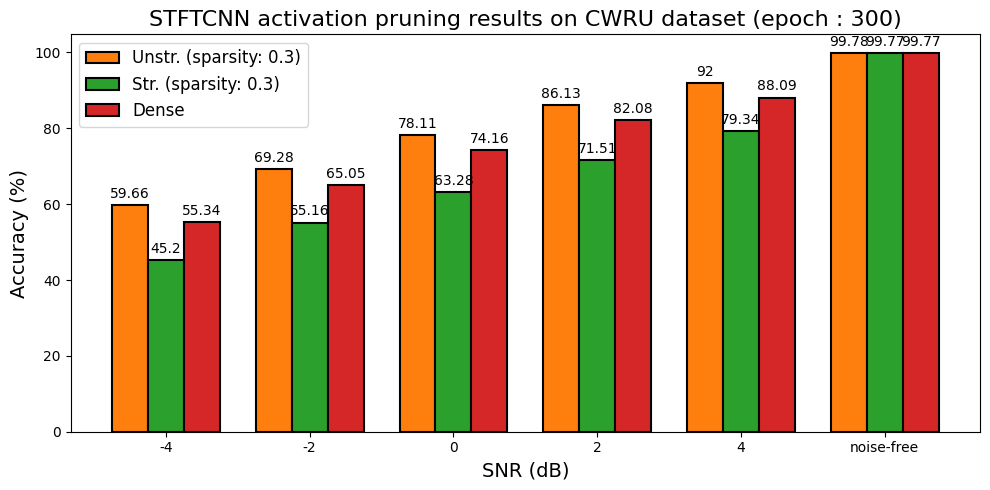

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))

noise_levels = ['-4', '-2', '0', '2', '4', 'noise-free']
x = np.arange(len(noise_levels))

width = 0.25
bar1 = ax.bar(x - width, round(stim_cnn_unstr, 2), width=width, label=f'Unstr. (sparsity: {sparsity})', color='C1', linewidth=1.5, edgecolor='black')
bar2 = ax.bar(x, round(stim_cnn_str, 2), width=width, label=f'Str. (sparsity: {sparsity})', color='C2', linewidth=1.5, edgecolor='black')
bar3 = ax.bar(x + width, round(stim_cnn_none, 2), width=width, label='Dense', color='C3', linewidth=1.5, edgecolor='black')

ax.bar_label(bar1, padding=3, fontsize=10)
ax.bar_label(bar2, padding=3, fontsize=10)
ax.bar_label(bar3, padding=3, fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(noise_levels)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("SNR (dB)", fontsize=14)
ax.legend(fontsize=12)
ax.set_title(f"{model_name.upper()} activation pruning results on {dataset_name.upper()} dataset (epoch : {epochs})", fontsize=16)

fig.tight_layout()

In [133]:
epochs = 100

cnn_unstr = means.loc[(str(epochs), 'activation', '0.3')]
cnn_none = means.loc[(str(epochs), 'none', 'None')]

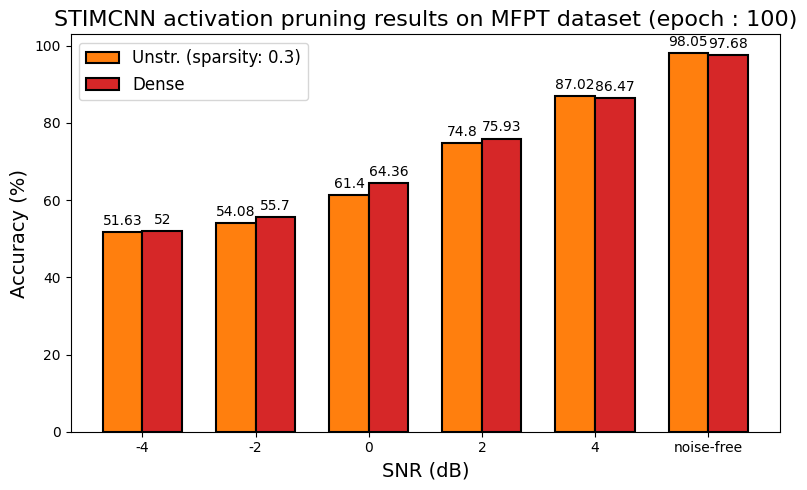

In [134]:
fig, ax = plt.subplots(figsize=(8, 5))

noise_levels = ['-4', '-2', '0', '2', '4', 'noise-free']
x = np.arange(len(noise_levels))

width = 0.35
bar1 = ax.bar(x - width/2, round(cnn_unstr, 2), width=width, label=f'Unstr. (sparsity: {sparsity})', color='C1', linewidth=1.5, edgecolor='black')
bar3 = ax.bar(x + width/2, round(cnn_none, 2), width=width, label='Dense', color='C3', linewidth=1.5, edgecolor='black')

ax.bar_label(bar1, padding=3, fontsize=10)
ax.bar_label(bar3, padding=3, fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(noise_levels)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("SNR (dB)", fontsize=14)
ax.legend(fontsize=12)
ax.set_title(f"{model_name.upper()} activation pruning results on {dataset_name.upper()} dataset (epoch : {epochs})", fontsize=16)

fig.tight_layout()

In [403]:
all_exps = mlflow.search_experiments()

with pd.ExcelWriter("231204_results.xlsx", date_format="YYYY-MM-DD", datetime_format='YYYY-MM-DD HH:MM:SS') as xlsx_writer:
    for exp in all_exps:
        if exp.name == "Default":
            continue
        
        df = mlflow.search_runs(
            experiment_ids=exp.experiment_id,
            filter_string="attributes.status = 'FINISHED'"
        )
        df['start_time'] = df['start_time'].dt.tz_convert(None)
        df['end_time'] = df['end_time'].dt.tz_convert(None)
        df.to_excel(xlsx_writer, sheet_name=exp.name)

Traceback (most recent call last):
  File "/data/home/akdakd55/.pyenv/versions/3.9.6/envs/cl/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 290, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/data/home/akdakd55/.pyenv/versions/3.9.6/envs/cl/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 383, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/data/home/akdakd55/.pyenv/versions/3.9.6/envs/cl/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1096, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/data/home/akdakd55/.pyenv/versions/3.9.6/envs/cl/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1089, in _read_helper
    result = read_yaml(root, file_name)
  File "/data/home/akdakd55/.pyenv/versions/3.9.6/envs/cl/lib/python3.9/site-packages/mlflow/utils/file_utils.py", lin

In [407]:
exps = mlflow.search_experiments(filter_string="name = 'Featuremap Pruning CWRU'")

In [418]:
stimcnn_runs = mlflow.search_runs(experiment_ids=exps[0].experiment_id, filter_string="params.model_name = 'stimcnn' and params.activation_drop = 'none'")

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val/loss,metrics.test/acc_cwru-4,metrics.train/loss_step,metrics.test/loss_cwru-2,...,params.activation_drop,params.num_workers,params.epochs,params.optimizer_name,tags.mlflow.source.git.commit,tags.Mode,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name
0,20ae70dfc5d040179815cbeec7a5240f,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-19 11:30:13.125000+00:00,2023-09-19 11:43:13.404000+00:00,0.005424,0.077754,0.000030,82.535736,...,none,2,300,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,valuable-moose-347,LOCAL,featuremap_prune.py
1,ecc6e683faf94910a7f397e1f450b86f,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-19 11:10:24.434000+00:00,2023-09-19 11:30:12.879000+00:00,0.003137,0.077754,0.000402,96.477440,...,none,2,300,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,inquisitive-croc-178,LOCAL,featuremap_prune.py
2,3a667de89ddc46d298ace62bf3a56675,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-19 10:48:24.268000+00:00,2023-09-19 11:10:24.094000+00:00,0.001608,0.077754,0.000057,81.483749,...,none,2,300,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,capable-bee-438,LOCAL,featuremap_prune.py
3,936fd09264f8421eac2b8107823091ea,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-19 10:27:14.796000+00:00,2023-09-19 10:48:23.847000+00:00,0.014499,0.077754,0.000038,92.655678,...,none,2,300,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,enthused-ape-338,LOCAL,featuremap_prune.py
4,a5bc024100a045a8a7402fec88011bbc,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-19 10:05:23.193000+00:00,2023-09-19 10:27:14.573000+00:00,0.028681,0.099352,0.001072,35.390419,...,none,2,300,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,charming-zebra-856,LOCAL,featuremap_prune.py
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,a1944cc9f85549d483c74ec3b3630b13,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-18 14:24:45.847000+00:00,2023-09-18 14:32:25.079000+00:00,0.057871,0.077754,0.000016,32.833500,...,none,2,100,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,big-perch-53,LOCAL,featuremap_prune.py
86,6c51c814b77146a8876e4fe43646a413,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-18 14:18:25.081000+00:00,2023-09-18 14:24:45.644000+00:00,0.006175,0.077754,0.000183,54.792137,...,none,2,100,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,intrigued-smelt-679,LOCAL,featuremap_prune.py
87,2552f8a22fe34ebfb2b6aaf4287c5bc4,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-18 14:12:15.429000+00:00,2023-09-18 14:18:24.604000+00:00,0.242453,0.408207,0.000834,14.972256,...,none,2,100,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,grandiose-skink-833,LOCAL,featuremap_prune.py
88,45818b52a4a24e4396c55a0ff406ce49,911293835925152270,FINISHED,file:///NIA_agri/home/akdakd55/sparse-bfd/mlru...,2023-09-18 14:06:36.972000+00:00,2023-09-18 14:12:15.073000+00:00,0.066766,0.294816,0.005083,10.584465,...,none,2,100,Adam,2ddaa147c3d61ec2d4e2bb1f91ad308d54aa5c59,testing,akdakd55,gregarious-cow-677,LOCAL,featuremap_prune.py


In [420]:
exps = mlflow.search_experiments()

In [426]:
exps

[<Experiment: artifact_location='file:///NIA_agri/home/akdakd55/sparse-bfd/mlruns/253889031117104830', creation_time=1700816538078, experiment_id='253889031117104830', last_update_time=1701750801471, lifecycle_stage='active', name='stransformer_ottawa', tags={}>,
 <Experiment: artifact_location='file:///NIA_agri/home/akdakd55/sparse-bfd/mlruns/662837566224034859', creation_time=1700638368996, experiment_id='662837566224034859', last_update_time=1701750814410, lifecycle_stage='active', name='stransformer_mfpt', tags={}>,
 <Experiment: artifact_location='file:///NIA_agri/home/akdakd55/sparse-bfd/mlruns/642473007874722001', creation_time=1700637444631, experiment_id='642473007874722001', last_update_time=1701750825580, lifecycle_stage='active', name='stransformer_cwru', tags={}>,
 <Experiment: artifact_location='file:///NIA_agri/home/akdakd55/sparse-bfd/mlruns/835412959674262003', creation_time=1697431383131, experiment_id='835412959674262003', last_update_time=1701750835502, lifecycle_st

In [483]:
runs = mlflow.search_runs(
    experiment_ids=[exp.experiment_id for exp in exps],
    filter_string="params.model_name = 'stftcnn' and params.datapath = 'data/cwru' and params.epochs = '100' and params.activation_drop = 'activation' and params.activation_sparsity = '0.9'"
)

KurtosistestResult(statistic=1.9722599355773724, pvalue=0.04857994073916332)

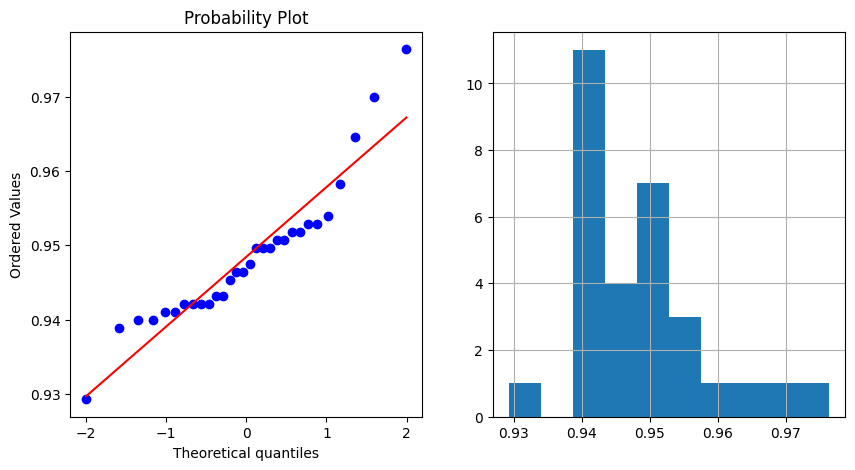

In [490]:
from scipy.stats import probplot, skewtest, kurtosistest

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

probplot(runs['metrics.test/acc_cwru0'], plot=axes[0])
runs['metrics.test/acc_cwru0'].hist(ax=axes[1])

skewtest(runs['metrics.test/acc_cwru0'])
kurtosistest(runs['metrics.test/acc_cwru0'])

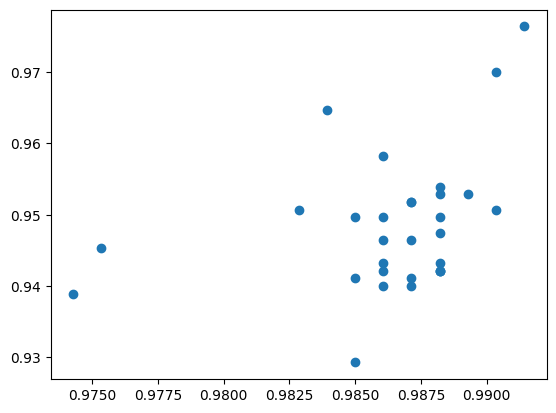

In [491]:
plt.scatter(x=runs['metrics.test/acc_cwru'], y=runs['metrics.test/acc_cwru0'])

<Axes: >

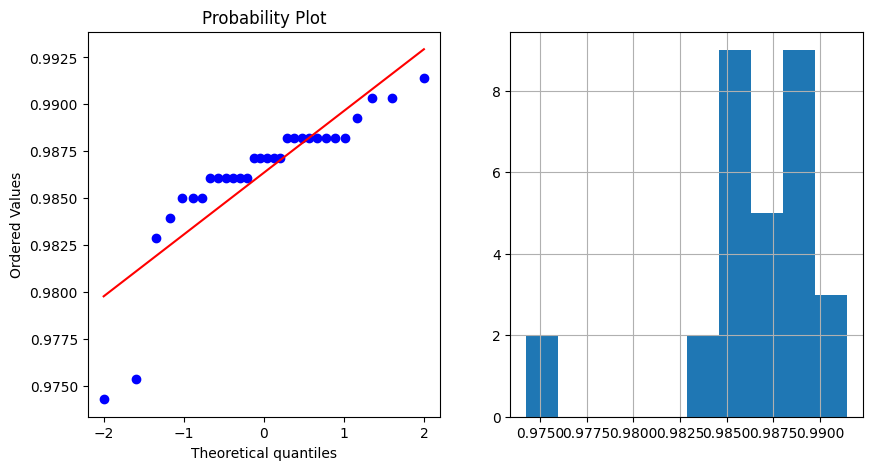

In [489]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

probplot(runs['metrics.test/acc_cwru'], plot=axes[0])
runs['metrics.test/acc_cwru'].hist(ax=axes[1])

In [575]:
from fault_diagnosis_baseline.fdob.download import download_cwru, download_mfpt, download_ottawa
from fault_diagnosis_baseline.fdob.processing import AWGN

In [537]:
cwru_df = download_cwru('data/cwru/')
mfpt_df = download_mfpt('data/mfpt')
ottawa_df = download_ottawa('data/ottawa/')

File is already existed, use existed file.
File is already existed, use existed file.


In [538]:
dataset_df = {
    'cwru': cwru_df,
    'mfpt': mfpt_df,
    'ottawa': ottawa_df
}
sample_rates = {
    'cwru': 12000,
    'ottawa': 48000,
}

In [544]:
dfs = {name: df[df['fault_type'] == 'N'] for name, df in dataset_df.items()}

In [554]:
dfs['ottawa']['data']

12    [-0.0021994445170026022, -0.001870597411696539...
13    [-0.0025282916222252594, -0.002199444517002602...
14    [0.0017467207521827538, 0.0007601794337580708,...
15    [0.005035191819041579, 0.002075567858491681, 0...
16    [0.008981357110350308, 0.010625592651970842, 0...
17    [-0.006145609774174471, -0.009434080812668083,...
18    [-0.004830221356449643, -0.0045013742518103805...
19    [0.002404414964884291, 0.0017467207521827538, ...
20    [0.0027332620713606537, 0.0037198033912923534,...
21    [0.0047063447119784635, 0.010625592651970842, ...
22    [-0.0045013742518103805, -0.003843680042281999...
23    [0.010625592651970842, 0.011940981086784236, 0...
Name: data, dtype: object

In [586]:
def plot_data(dataset_df: dict, fault_type: str, duration: float, sample_idx: int=0, segment_idx: int=0, noise=False, mfpt_downsample=False):
    fault_df = {name: df[df['fault_type'] == fault_type] for name, df in dataset_df.items()}

    samples = dict()

    for name, df in fault_df.items():
        num_samples = len(df)
        if num_samples == 0:
            continue
        elif sample_idx >= num_samples:
            idx = sample_idx % num_samples
        else:
            idx = sample_idx

        if name == 'cwru':
            sample_rate = 12000
        elif name == 'mfpt':
            sample_rate = df['sampling_rate'].iloc[idx]
        else:
            sample_rate = 48000

        sample = df['data'].iloc[idx]
        window_len = int(duration * sample_rate)
        lb = window_len * segment_idx
        ub = lb + window_len

        try:
            sample_data = sample[lb:ub]

        except IndexError as e:
            raise e(f"Index exceeded '{name}' '{fault_type}' sample boundary")

        if name == 'mfpt' and mfpt_downsample and sample_rate > 90000:
            sample_data = sample_data[::2]
            sample_rate = sample_rate // 2
        if noise:
            sample_data = AWGN(0.)(sample_data)

        samples[name] = (sample_data, sample_rate)

    if not list(samples.keys()):
        raise ValueError(f"There are no datasets which has the '{fault_type}' fault type.")
    
    nrow = len(list(samples.keys()))

    fig, axes = plt.subplots(nrow, 2, figsize=(10, 5 * nrow))

    for i, (name, (data, sr)) in enumerate(samples.items()):

        fft = np.fft.fft(data)
        amp = abs(fft) * (2/len(fft))
        freq = np.fft.fftfreq(len(fft), 1/sr)

        axes[i, 0].plot(data)
        axes[i, 0].set_title(f"{name.upper()} {fault_type} ({duration}s)")
        axes[i, 1].stem(freq, amp)
        axes[i, 1].set_xlim(0)
        axes[i, 1].set_title(f"{name.upper()} {fault_type} FFT")

    fig.tight_layout()

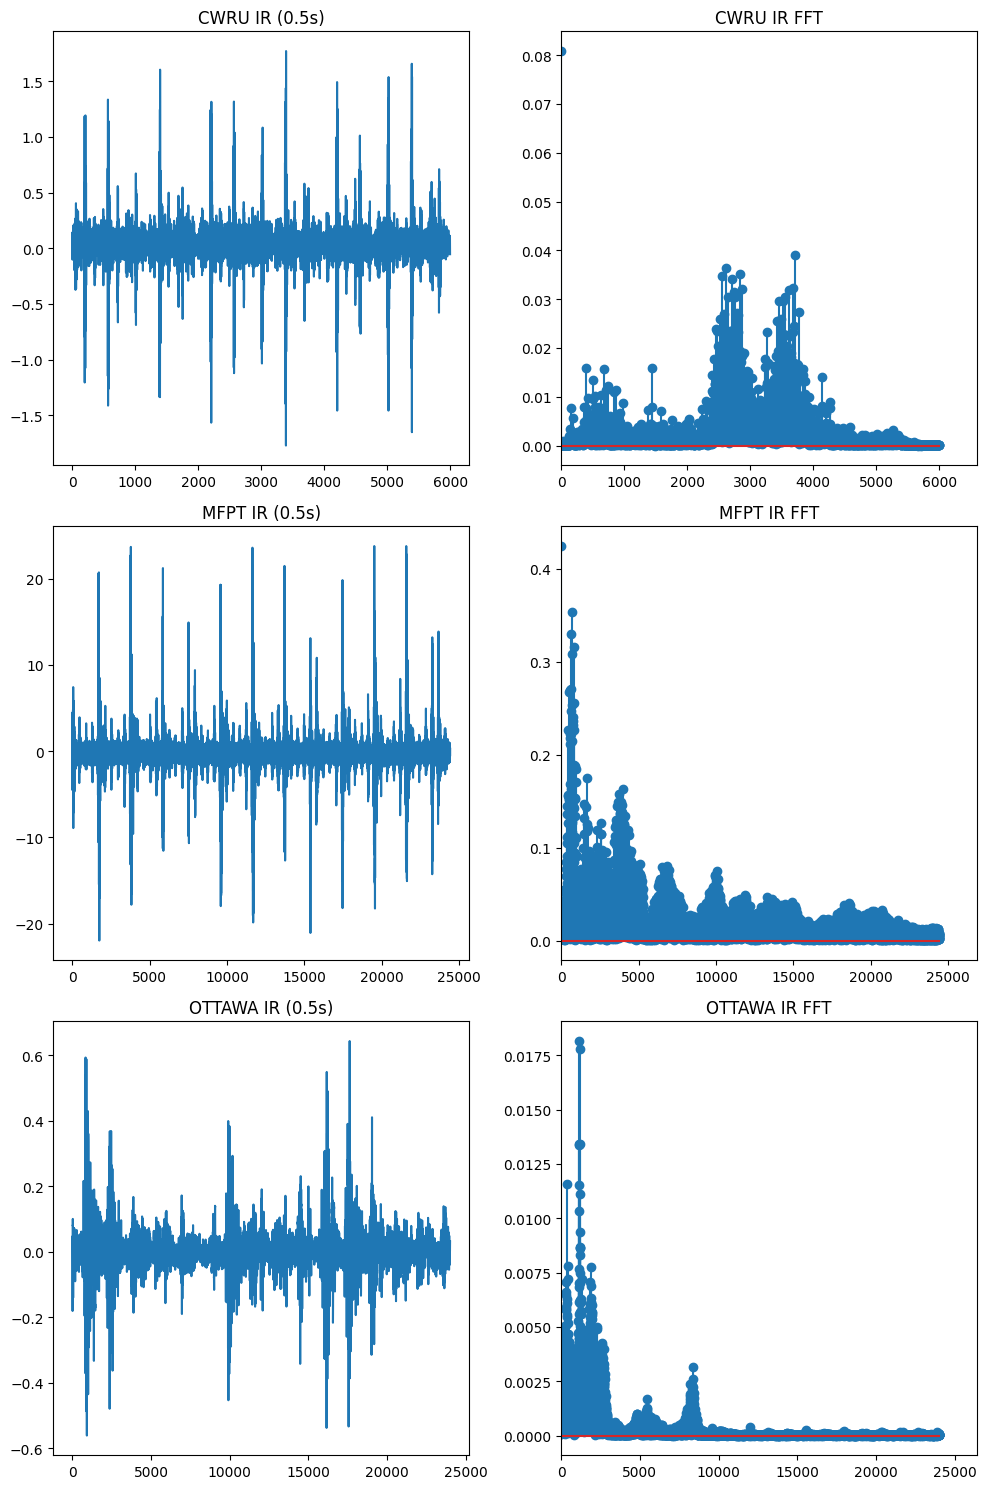

In [593]:
plot_data(dataset_df, 'IR', 0.5, 4, 5)

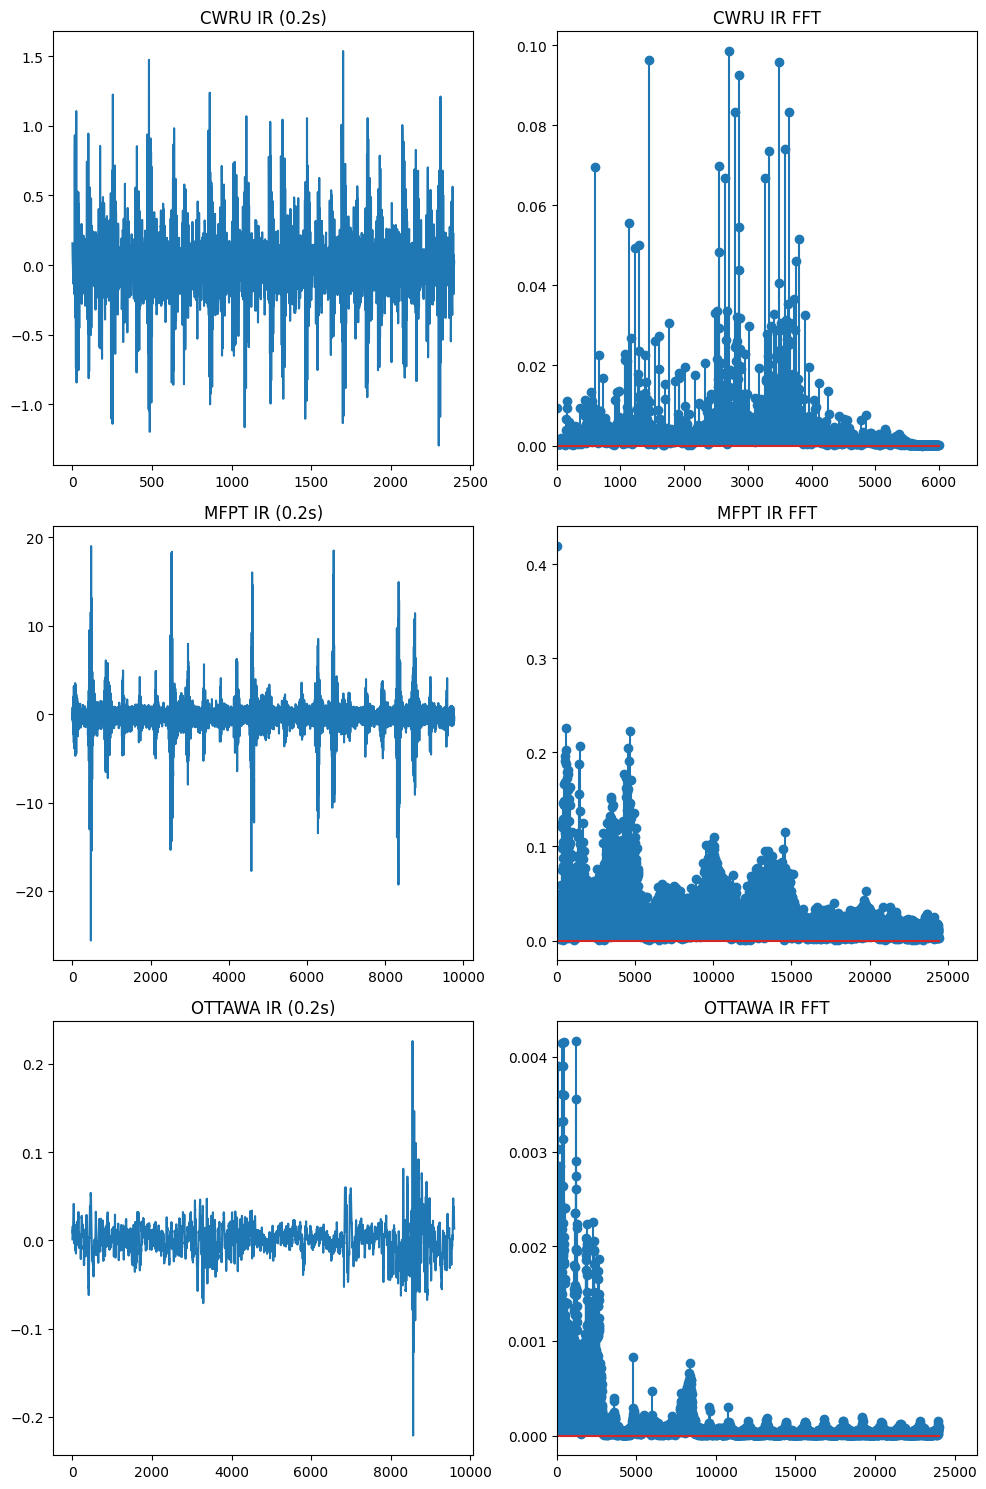

In [595]:
plot_data(dataset_df, 'IR', 0.2, 2, 5, mfpt_downsample=True)

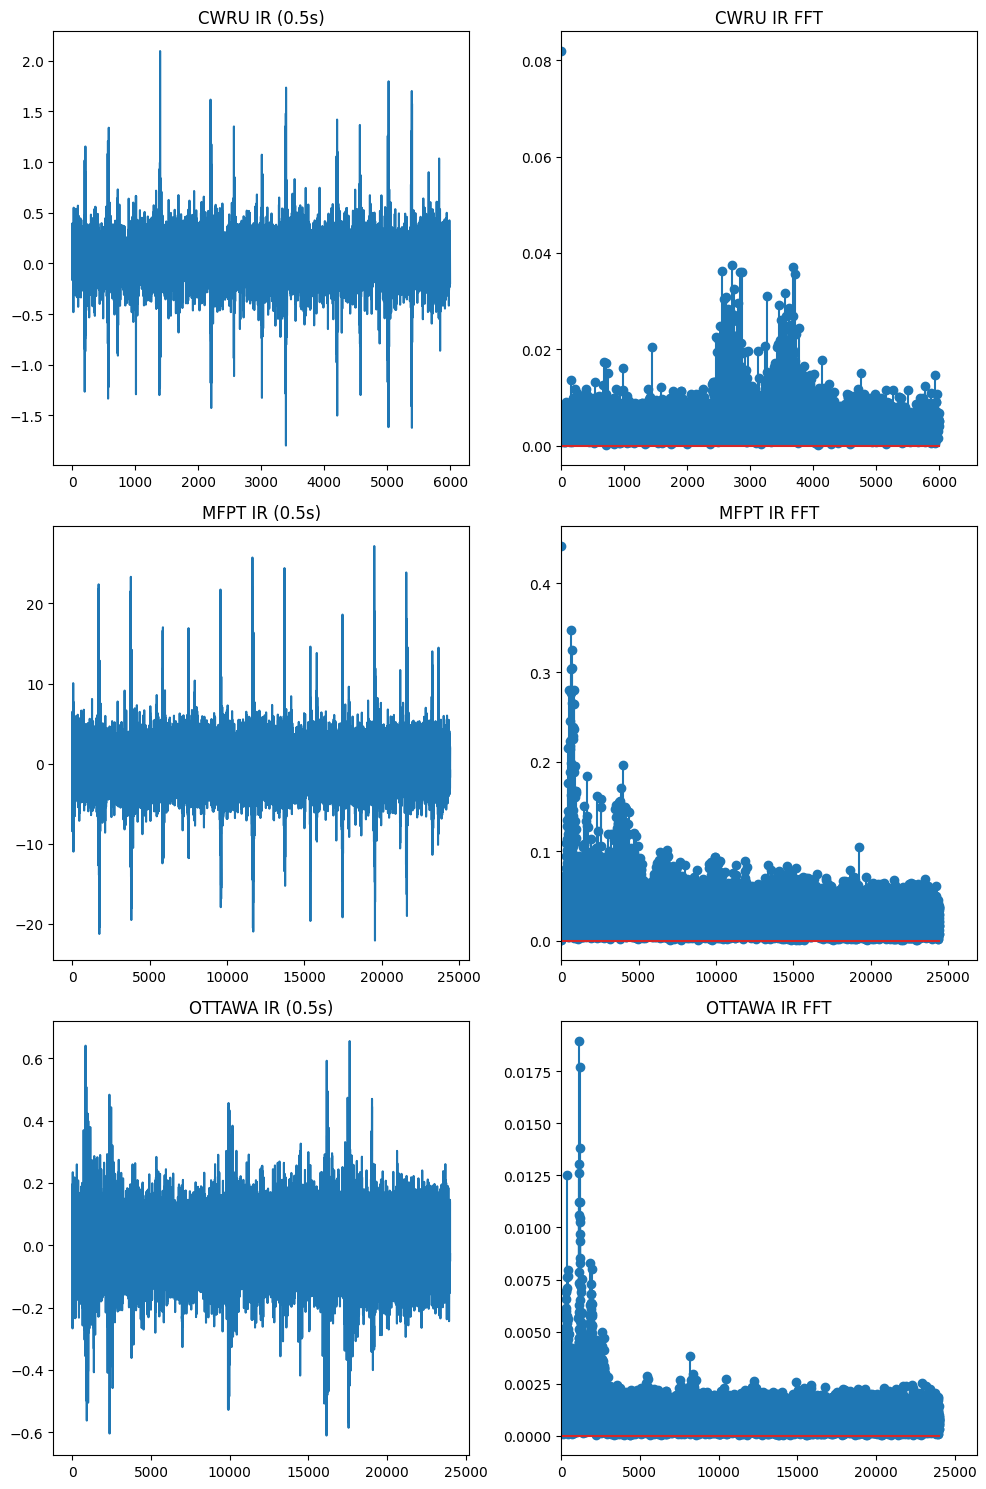

In [594]:
plot_data(dataset_df, 'IR', 0.5, 4, 5, noise=True)